## Установка зависимостей

In [1]:
%pip install -r requirements.txt -q
%pip install natasha -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
import nltk
nltk.download('brown')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\vladimir\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vladimir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vladimir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladimir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize
import json
from natasha import MorphVocab, Doc, Segmenter, NewsMorphTagger, NewsEmbedding
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time

### Считываение датасета и объединение всех ответов в один массив

In [38]:
def dataset_to_text(dataset_path: str):
    with open(dataset_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    texts = []
    for answer in data["answers"]:
        texts.extend(answer)
    return texts

In [53]:
DATASET_PATH = 'datasets/small_dataset_20.json'
texts = dataset_to_text(DATASET_PATH)

### Приведение к нижнему регистру

In [54]:
def to_lowercase(sentence: str) -> str:
    return sentence.lower()

In [55]:
texts = list(map(to_lowercase, texts))

### Лемматизация и удаление стоп-слов

In [56]:
def remove_stopwords(sentence: str) -> str:
    # Получаем список стоп-слов для русского и английского языков
    stop_words_russian = set(stopwords.words('russian'))
    stop_words_english = set(stopwords.words('english'))
    
    # Объединяем два набора стоп-слов
    stop_words = stop_words_russian.union(stop_words_english)
    
    # Токенизируем предложение
    words = word_tokenize(sentence)
    
    # Фильтруем предложение, удаляя стоп-слова
    filtered_sentence = [word for word in words if word.lower() not in stop_words]
    
    return ' '.join(filtered_sentence)

In [57]:
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
morph_vocab = MorphVocab()

def lemmatize(sentence: str) -> str:
    lemmatized = ''
    doc = Doc(sentence)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        #print(token.text, token.lemma)
        lemmatized += token.lemma + ' '
    return lemmatized.strip()

In [58]:
lemmatized_texts = []
lemmatize_dict = {}

for sentence in texts:
    lemmatized_sentence = lemmatize(remove_stopwords(sentence))
    lemmatize_dict[lemmatized_sentence] = sentence
    lemmatized_texts.append(lemmatized_sentence)
    
lemmatized_texts = list(map(remove_stopwords, lemmatized_texts))

In [59]:
def count_words_phrases(lemmatized_texts):
    word_count = Counter(lemmatized_texts)
    return dict(word_count)

word_freq_dict = count_words_phrases(lemmatized_texts)

### Получение эмбеддингов 

In [31]:
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load_word2vec_format("ruwiki_20180420_300d.txt")

def get_word2vec_embedding(word: str):
    try:
        if len(word.split()) == 1:
            vector = word2vec_model.get_vector(word, norm=True).reshape(-1)
        else:
            vector = word2vec_model.get_vector(word.split()[-1], norm=True).reshape(-1)
        return vector
    except Exception as e:
        vector = [0 for i in range(300)]
    finally:
        return vector

In [60]:
import numpy as np
from tqdm import tqdm
embeddings = []
for sentence in tqdm(lemmatized_texts):
    embeddings.append(get_word2vec_embedding(sentence))

embeddings = np.array(embeddings)

100%|██████████| 100/100 [00:00<00:00, 99721.92it/s]


### Кластеризация

In [66]:
# agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0, linkage='ward')
# labels = agglomerative.fit_predict(embeddings)

dbscan = DBSCAN(eps=1.0, min_samples=1)
labels = dbscan.fit_predict(embeddings)

word_clusters = defaultdict(list)
for word, label in zip(word_freq_dict.keys(), labels):
    word_clusters[label].append(word)

# Вывод кластеров
print("Кластеры слов:")
for label, cluster_words in word_clusters.items():
    print(f"Кластер {label}: {', '.join(cluster_words)}")

Кластеры слов:
Кластер 0: семья, творчество, экологический след
Кластер 1: хороший друг, друг, самодостаточность, автономия, эмоциональный здоровье
Кластер 2: любовь, покой, природа
Кластер 3: крепкий здоровье, здоровье, устойчивость
Кластер 4: карьера, эффективность, собственный комфорт
Кластер 5: свободный
Кластер 6: деньга, новый опыт
Кластер 7: развитие, самореализация, экология, принятие, интерьер
Кластер 8: удовлетворение, адаптивность, выбор, уют
Кластер 9: признание, фокус
Кластер 10: доверие, эмоция, духовность, спокойствие, цель, удовольствие, гибкость, сохранение ресурс, независимость, личный пространство, поддержка, единство, инновация
Кластер 11: хобби
Кластер 12: путешествие, рост
Кластер 13: работа
Кластер 14: успех, многозадачность
Кластер 15: гармония, личный граница
Кластер 16: свобода, уверенность, дом
Кластер 17: достижение, самоценность
Кластер 18: амбиция
Кластер 19: стабильность
Кластер 20: понимание
Кластер 21: эмпатия
Кластер 22: вдохновение, мотивация
Кластер 

In [67]:
# Подсчет частоты слов в Brown Corpus (для сравнительной частоты в языке)
brown_freq = Counter(brown.words())

def lemma_replacement(lemma: str) -> str:
    if lemma in lemmatize_dict.keys():
        return lemmatize_dict[lemma]
    return lemma

# Функция для выбора самого частого слова в кластере
def select_most_frequent_word(cluster_words, word_freq_dict):
    """
    Выбирает самое популярное слово в кластере, исходя из частоты встречаемости
    в текущем словаре word_freq_dict. При равной частоте использует частоту в языке (brown_freq).
    """
    # Сортировка слов по частоте встречаемости в словаре, а при равенстве — по частоте в языке
    sorted_words = sorted(
        cluster_words,
        key=lambda word: (-word_freq_dict[word], -brown_freq.get(word, 0))
    )
    return sorted_words[0]  # Возвращаем наиболее популярное слово

# Формируем итоговый словарь: ключ — наиболее частое слово, значение — сумма встречаемости слов в кластере
def form_final_word_dict(word_clusters, word_freq_dict):
    final_word_dict = {}
    
    for label, cluster_words in word_clusters.items():
        # Выбираем самое частое слово в кластере
        most_frequent_word = select_most_frequent_word(cluster_words, word_freq_dict)
        
        # Суммируем частоты встречаемости всех слов в кластере
        cluster_word_count_sum = sum(word_freq_dict[word] for word in cluster_words)
        
        # Добавляем в итоговый словарь: ключ — самое частое слово, значение — сумма частот всех слов в кластере
        final_word_dict[most_frequent_word] = cluster_word_count_sum
    
    return final_word_dict

# Формируем итоговый словарь
final_word_dict = form_final_word_dict(word_clusters, word_freq_dict)

def lemma_replacement(lemma: str) -> str:
    if lemma in lemmatize_dict.keys():
        return lemmatize_dict[lemma]
    return lemma

def replace_keys_by_function(d, func):
    return {func(k): v for k, v in d.items()}
final_word_dict = replace_keys_by_function(final_word_dict, lemma_replacement)

# Вывод результата
print("Итоговый словарь с частотами слов в кластерах:")
for word, count in final_word_dict.items():
    print(f"Слово: {word}, Сумма встречаемости в кластере: {count}")

Итоговый словарь с частотами слов в кластерах:
Слово: семья, Сумма встречаемости в кластере: 5
Слово: друзья, Сумма встречаемости в кластере: 8
Слово: любовь к себе, Сумма встречаемости в кластере: 7
Слово: здоровье, Сумма встречаемости в кластере: 4
Слово: карьера, Сумма встречаемости в кластере: 5
Слово: быть свободным, Сумма встречаемости в кластере: 1
Слово: деньги, Сумма встречаемости в кластере: 3
Слово: развитие, Сумма встречаемости в кластере: 8
Слово: удовлетворение, Сумма встречаемости в кластере: 4
Слово: признание, Сумма встречаемости в кластере: 3
Слово: доверие, Сумма встречаемости в кластере: 19
Слово: хобби, Сумма встречаемости в кластере: 1
Слово: путешествия, Сумма встречаемости в кластере: 4
Слово: работа, Сумма встречаемости в кластере: 1
Слово: успех, Сумма встречаемости в кластере: 3
Слово: гармония, Сумма встречаемости в кластере: 3
Слово: свобода, Сумма встречаемости в кластере: 5
Слово: достижения, Сумма встречаемости в кластере: 3
Слово: амбиции, Сумма встреча

### Построение облака слов

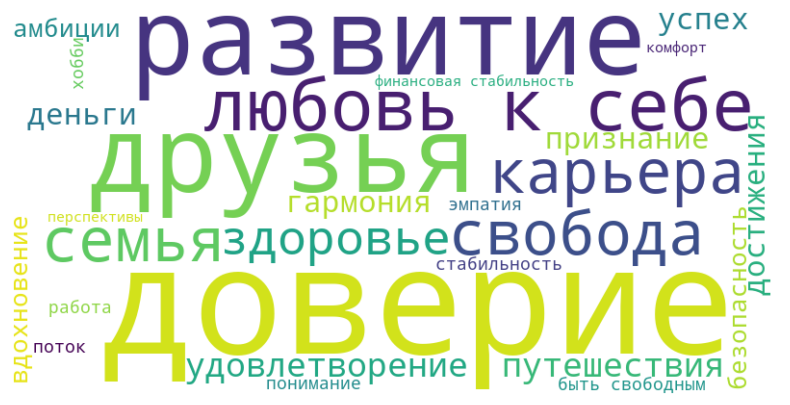

In [68]:
def generate_word_cloud(word_dict):
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(word_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_word_cloud(final_word_dict)

### Гистограмма распределения слов

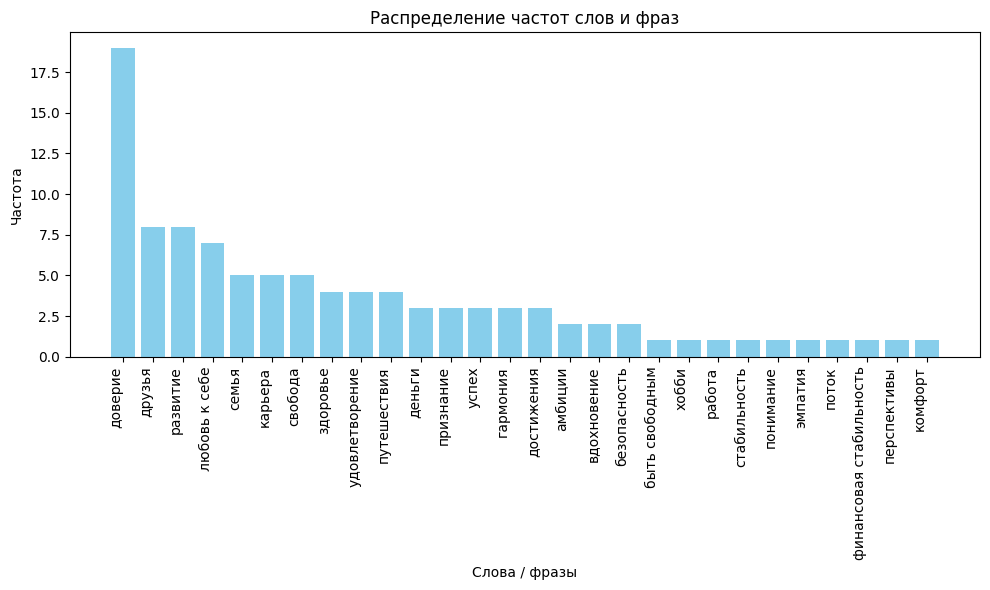

In [69]:
def plot_word_histogram(word_dict: dict) -> None:
    sorted_word_dict = dict(sorted(word_dict.items(), key=lambda item: item[1], reverse=True))
    
    words = list(sorted_word_dict.keys())
    frequencies = list(sorted_word_dict.values())

    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies, color='skyblue')
    plt.ylabel('Частота')
    plt.xlabel('Слова / фразы')
    plt.title('Распределение частот слов и фраз')
    plt.xticks(rotation=90, ha='right')  # Поворачиваем метки на оси X для удобства
    plt.tight_layout()
    plt.show()
    
plot_word_histogram(final_word_dict)